In [274]:
import os
import uuid
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
from hurst import compute_Hc
from untrade.client import Client

import warnings 
warnings.filterwarnings("ignore")

def process_data(data):
    class Indicators:
        """
        Class to calculate technical indicators using class methods on OHLCV data.
        """
        data = None  

        @classmethod
        def initialize(cls, data: pd.DataFrame):
            """Initialize the class with a DataFrame."""
            if not all(col in data.columns for col in ['open', 'high', 'low', 'close', 'volume']):
                raise ValueError("DataFrame must contain 'open', 'high', 'low', 'close', and 'volume' columns")
            cls.data = data.copy()

        @classmethod
        def calculate_prev_ohlcv(cls):
            """Calculate previous OHLCV columns by shifting current values."""
            cls.data['prev_open'] = cls.data['open'].shift(1)
            cls.data['prev_high'] = cls.data['high'].shift(1)
            cls.data['prev_low'] = cls.data['low'].shift(1)
            cls.data['prev_close'] = cls.data['close'].shift(1)
            cls.data['prev_volume'] = cls.data['volume'].shift(1)
            cls.data.dropna(subset=['prev_open', 'prev_high', 'prev_low', 'prev_close', 'prev_volume'], inplace=True)

        @classmethod
        def apply_kalman_filter(cls, transition_covariance: float = 0.01):
            """Apply Kalman Filter to prev_close."""
            prices = cls.data['prev_close'].dropna().values.reshape(-1, 1)
            kf = KalmanFilter(
                transition_matrices=[1],
                observation_matrices=[1],
                initial_state_mean=prices[0] if len(prices) > 0 else 0,
                initial_state_covariance=1,
                observation_covariance=0.1,
                transition_covariance=transition_covariance
            )
            state_means, _ = kf.filter(prices)
            cls.data['prev_filtered_close'] = pd.Series(state_means.flatten(), index=cls.data['prev_close'].dropna().index)

        @classmethod
        def rolling_hurst_exponent(cls, window: int = 100):
            """Calculate Hurst Exponent in a rolling window."""
            def hurst_exponent(ts):
                if len(ts) < 20 or np.any(np.isnan(ts)) or np.std(ts) == 0:
                    return np.nan
                try:
                    H, _, _ = compute_Hc(ts)
                    return H if 0 <= H <= 1 else np.nan
                except:
                    return np.nan
            cls.data['hurst'] = cls.data['prev_close'].rolling(window=window, min_periods=window).apply(hurst_exponent, raw=True)

        @classmethod
        def calculate_cusum(cls, window: int = 4, delta: float = 0.8):
            """Calculate CUSUM indicators."""
            rolling_sigma = cls.data['prev_close'].rolling(window=window).std()
            k = delta * rolling_sigma.fillna(0)
            price = cls.data['prev_close'].values
            mu = cls.data['prev_filtered_close'].values
            S_hi = np.zeros(len(cls.data))
            S_lo = np.zeros(len(cls.data))
            for i in range(1, len(cls.data)):
                S_hi[i] = max(0, S_hi[i-1] + (price[i] - mu[i] - k.iloc[i]))
                S_lo[i] = max(0, S_lo[i-1] + (-price[i] + mu[i] - k.iloc[i]))
            cls.data['cusum_hi'] = S_hi
            cls.data['cusum_lo'] = S_lo

        @classmethod
        def calculate_fdi(cls, window: int = 35):
            """Calculate Fractal Dimension Index."""
            def fractal_dimension(series):
                n = len(series)
                if n <= 1 or np.all(np.isnan(series)):
                    return np.nan
                L = np.sum(np.abs(np.diff(series)))
                d = np.max(np.abs(series - series[0]))
                return np.log(n) / (np.log(n) + np.log(d / L)) if L != 0 and d != 0 else np.nan
            cls.data['fdi'] = cls.data['prev_filtered_close'].rolling(window=window, min_periods=window).apply(fractal_dimension, raw=True)

        @classmethod
        def calculate_supertrend(cls, atr_length=14, factor=3.0):
            """Calculate Supertrend indicator."""
            cls.data['tr'] = np.maximum(
                cls.data['prev_high'] - cls.data['prev_low'],
                np.maximum(
                    abs(cls.data['prev_high'] - cls.data['prev_close'].shift(1)),
                    abs(cls.data['prev_low'] - cls.data['prev_close'].shift(1))
                )
            )
            cls.data['atr'] = cls.data['tr'].rolling(window=atr_length).mean()
            hl2 = (cls.data['prev_high'] + cls.data['prev_low']) / 2
            upper_band = hl2 + (factor * cls.data['atr'])
            lower_band = hl2 - (factor * cls.data['atr'])
            supertrend = [0] * len(cls.data)
            direction = [1] * len(cls.data)
            for i in range(1, len(cls.data)):
                if cls.data['prev_close'].iloc[i] > upper_band.iloc[i-1]:
                    supertrend[i] = lower_band.iloc[i]
                    direction[i] = -1
                elif cls.data['prev_close'].iloc[i] < lower_band.iloc[i-1]:
                    supertrend[i] = upper_band.iloc[i]
                    direction[i] = 1
                else:
                    supertrend[i] = supertrend[i-1]
                    direction[i] = direction[i-1]
            cls.data['supertrend'] = supertrend
            cls.data['supertrend_direction'] = direction

        @classmethod
        def calculate_rsi(cls, lengths=[14, 7]):
            """Calculate RSI for multiple lengths."""
            for length in lengths:
                delta = cls.data['prev_close'].diff()
                gain = np.where(delta > 0, delta, 0)
                loss = np.where(delta < 0, -delta, 0)
                avg_gain = pd.Series(gain, index=cls.data.index).rolling(window=length, min_periods=1).mean()
                avg_loss = pd.Series(loss, index=cls.data.index).rolling(window=length, min_periods=1).mean()
                rs = avg_gain / avg_loss
                cls.data[f'rsi_{length}'] = 100 - (100 / (1 + rs))

        @classmethod
        def calculate_macd(cls, fast_length=6, slow_length=12, signal_length=18):
            """Calculate MACD indicator."""
            fast_ema = cls.data['prev_close'].ewm(span=fast_length, adjust=False).mean()
            slow_ema = cls.data['prev_close'].ewm(span=slow_length, adjust=False).mean()
            cls.data['macd'] = fast_ema - slow_ema
            cls.data['macd_signal'] = cls.data['macd'].ewm(span=signal_length, adjust=False).mean()
            cls.data['macd_histogram'] = cls.data['macd'] - cls.data['macd_signal']

        @classmethod
        def calculate_bollinger_bands(cls, window: int = 14, num_std: float = 2.5):
            """Calculate Bollinger Bands."""
            cls.data['bb_middle'] = cls.data['prev_close'].rolling(window=window).mean()
            rolling_std = cls.data['prev_close'].rolling(window=window).std()
            cls.data['bb_upper'] = cls.data['bb_middle'] + (rolling_std * num_std)
            cls.data['bb_lower'] = cls.data['bb_middle'] - (rolling_std * num_std)

        @classmethod
        def identify_regimes(cls, window: int = 5, delta: float = 0.8, h_factor=1.5):
            """Identify market regimes."""
            rolling_sigma = cls.data['prev_close'].rolling(window=window).std()
            k = delta * rolling_sigma
            rolling_h = h_factor * rolling_sigma
            cls.data['regime'] = np.select(
                [
                    (cls.data['cusum_hi'] > rolling_h) & (cls.data['hurst'] > 0.5) & (cls.data['fdi'] < 1.5),
                    (cls.data['cusum_lo'] > rolling_h) & (cls.data['hurst'] > 0.5) & (cls.data['fdi'] < 1.5)
                ],
                ['bullish', 'bearish'],
                default='No Trend'
            )

        @classmethod
        def calculate_atr(cls, period: int = 21):
            """Calculate Average True Range (ATR)."""
            # True Range (TR) is the maximum of:
            # 1. Current high - current low
            # 2. abs(current high - previous close)
            # 3. abs(current low - previous close)
            cls.data['prev_close'] = cls.data['close'].shift(1)
        
            high_low = cls.data['high'] - cls.data['low']
            high_prev_close = abs(cls.data['high'] - cls.data['prev_close'])
            low_prev_close = abs(cls.data['low'] - cls.data['prev_close'])
        
            cls.data['tr'] = np.maximum.reduce([high_low, high_prev_close, low_prev_close])
        
            # ATR using Wilder's smoothing (similar to EMA with adjust=False)
            cls.data['atr'] = cls.data['tr'].ewm(span=period, adjust=False).mean()


    # Calculate Indicators
    Indicators.initialize(data)
    Indicators.calculate_prev_ohlcv()
    Indicators.apply_kalman_filter()
    Indicators.rolling_hurst_exponent()
    Indicators.calculate_cusum()
    Indicators.calculate_fdi()
    Indicators.calculate_supertrend()
    Indicators.calculate_rsi()
    Indicators.calculate_macd()
    Indicators.calculate_bollinger_bands()
    Indicators.identify_regimes()

    return Indicators.data

def strat(data):
    """
    Strategy function to generate trading signals based on technical indicators.
    """
    # Initialize signals and trade_type column
    data['signals'] = 0
    data['trade_type'] = " "

    atr_percentile= 0.06
    
    # Set ATR breakout threshold
    atr_threshold = data['atr'].quantile(atr_percentile)

    # Helper function to close positions
    def close_position(stoploss=False):
        nonlocal current_position, entry_price, highest_since_entry, lowest_since_entry
        if i < len(data) - 1:  # Ensure we don't go out of bounds
            if current_position == 1:
                data.at[data.index[i + 1], 'signals'] = -1
                data.at[data.index[i + 1], 'trade_type'] = 'close'
            elif current_position == -1:
                data.at[data.index[i + 1], 'signals'] = 1
                data.at[data.index[i + 1], 'trade_type'] = 'close'
            current_position = 0
            entry_price = None
            highest_since_entry = None
            lowest_since_entry = None

    # Trading Variables
    current_position = 0  # 0 = no position, 1 = long, -1 = short
    entry_price = None
    highest_since_entry = None
    lowest_since_entry = None

    # Strategy Parameters
    TRAILING_STOPLOSS_PCT_LONG = 0.25
    TRAILING_STOPLOSS_PCT_SHORT = 0.05

    # Main loop to process data
    for i in range(len(data)):
        current_price = data['prev_close'].iloc[i]

        # Trailing stop-loss for long positions
        if current_position == 1:
            highest_since_entry = max(highest_since_entry or current_price, current_price)
            trailing_stop_price = highest_since_entry * (1 - TRAILING_STOPLOSS_PCT_LONG)
            if current_price <= trailing_stop_price:
                close_position(stoploss=True)
                continue

        # Trailing stop-loss for short positions
        elif current_position == -1:
            lowest_since_entry = min(lowest_since_entry or current_price, current_price)
            trailing_stop_price = lowest_since_entry * (1 + TRAILING_STOPLOSS_PCT_SHORT)
            if current_price >= trailing_stop_price:
                close_position(stoploss=True)
                continue

        # LONG ENTRY CONDITIONS
        if current_position == 0 and i + 1 < len(data):
            if (
                data['regime'].iloc[i] == 'bullish' and
                data['macd_histogram'].iloc[i] > 0 and
                data['macd_histogram'].iloc[i] > data['macd_histogram'].iloc[i-1] and
                data['prev_close'].iloc[i] > data['bb_upper'].iloc[i] and
                data['rsi_14'].iloc[i] > 70 and
                data['atr'].iloc[i] > atr_threshold
            ):
                data.at[data.index[i + 1], 'signals'] = 1
                data.at[data.index[i + 1], 'trade_type'] = 'long'
                current_position = 1
                entry_price = current_price
                highest_since_entry = current_price

            # SHORT ENTRY CONDITIONS
            elif (
                data['regime'].iloc[i] == 'bearish' and
                data['macd_histogram'].iloc[i] < 0 and
                data['macd_histogram'].iloc[i] < data['macd_histogram'].iloc[i-1] and
                data['prev_close'].iloc[i] < data['bb_lower'].iloc[i] and
                data['rsi_14'].iloc[i] < 30 and
                data['atr'].iloc[i] > atr_threshold
            ):
                data.at[data.index[i + 1], 'signals'] = -1
                data.at[data.index[i + 1], 'trade_type'] = 'short'
                current_position = -1
                entry_price = current_price
                lowest_since_entry = current_price

        # LONG EXIT CONDITIONS
        elif current_position == 1 and (
            (
                data['regime'].iloc[i] == 'bearish' and
                data['supertrend_direction'].iloc[i] == -1 and
                data['prev_close'].iloc[i] < data['bb_lower'].iloc[i] and
                data['macd_histogram'].iloc[i] < 0
            ) or (
                data['macd_histogram'].iloc[i] < 0 and
                data['rsi_14'].iloc[i] > 80
            )
        ):
            close_position()

        # SHORT EXIT CONDITIONS
        elif current_position == -1 and (
            (
                data['regime'].iloc[i] == 'bullish' and
                data['supertrend_direction'].iloc[i] == 1 and
                data['prev_close'].iloc[i] > data['bb_upper'].iloc[i] and
                data['macd_histogram'].iloc[i] > 0
            ) or (
                data['macd_histogram'].iloc[i] > 0 and
                data['rsi_14'].iloc[i] < 20
            )
        ):
            close_position()

    return data

def perform_backtest(csv_file_path):
    """Perform backtesting using the untrade SDK."""
    client = Client()
    result = client.backtest(
        jupyter_id="team_akatsuki",
        file_path=csv_file_path,
        leverage=5,
    )
    return result

    
def perform_backtest(csv_file_path):
    """Perform backtesting using the untrade SDK."""
    client = Client()
    result = client.backtest(
        jupyter_id="team_akatsuki",
        file_path=csv_file_path,
        leverage=5,
    )
    return result

def main():
    global data
    # Example usage (uncomment and adjust path as needed)
    #df = pd.read_csv('BTC_2017_2025_1h.csv', parse_dates=['datetime'])
    #data = process_data(df)
    strategized_data = strat(data)
    
    csv_file_path = "BTC_strategy_results.csv"
    strategized_data.to_csv(csv_file_path, index=False)
    
    # backtest_result = perform_backtest(csv_file_path)
    # last_value = None
    # for value in backtest_result:
    #     last_value = value
    # print(last_value)

if __name__ == "__main__":
    main()

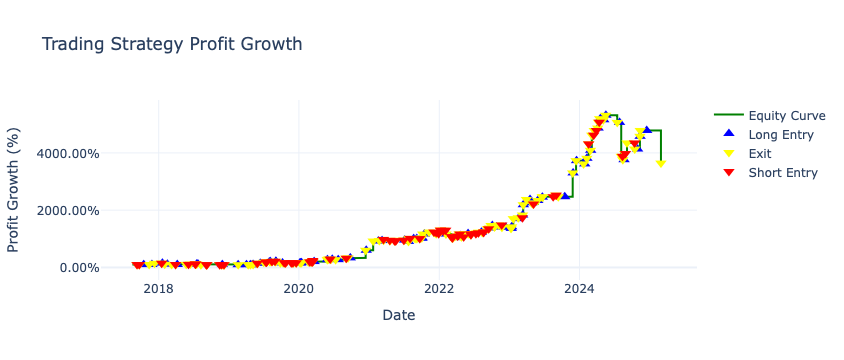

Total Return: 3544.01%
Maximum Drawdown: -37.31%


In [275]:
import pandas as pd
import plotly.graph_objects as go

df=pd.read_csv('BTC_strategy_results.csv')

# Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

def calculate_profit_growth(df):
    position = 0  # 0: no position, 1: long, -1: short
    entry_price = 0
    cumulative_return = 100  # Starting value
    returns = []

    for idx, row in df.iterrows():
        if position == 0:  # No position
            if row['signals'] == 1:  # Long entry

                
                position = 1
                entry_price = row['close']
            elif row['signals'] == -1:  # Short entry
                position = -1
                entry_price = row['close']
            returns.append(cumulative_return)
            
        elif position == 1:  # In long position
            if row['signals'] == -1:  # Long exit
                position = 0
                pct_change = (row['close'] - entry_price) / entry_price
                cumulative_return *= (1 + pct_change)
                entry_price = 0
            returns.append(cumulative_return)
            
        elif position == -1:  # In short position
            if row['signals'] == 1:  # Short exit
                position = 0
                pct_change = (entry_price - row['close']) / entry_price
                cumulative_return *= (1 + pct_change)
                entry_price = 0
            returns.append(cumulative_return)
    
    return pd.Series(returns, index=df.index)

# Calculate cumulative returns
df['cumulative_returns'] = calculate_profit_growth(df)



# Identify long and short entry and exit points using 'trade_type' column
long_entries = df[df['trade_type'] == 'long']
exits = df[df['trade_type'] == 'close']
short_entries = df[df['trade_type'] == 'short']
# short_exits = df[df['trade_type'] == 'close']

# Create the plot
fig = go.Figure()

# Add the equity curve
fig.add_trace(go.Scatter(
    x=df['datetime'],
    y=df['cumulative_returns'],
    mode='lines',
    name='Equity Curve',
    line=dict(color='green', width=2)
))

# Add long entry markers (blue)
fig.add_trace(go.Scatter(
    x=long_entries['datetime'],
    y=long_entries['cumulative_returns'],
    mode='markers',
    name='Long Entry',
    marker=dict(color='blue', size=10, symbol='triangle-up')
))

# Add long exit markers (cyan)
fig.add_trace(go.Scatter(
    x=exits['datetime'],
    y=exits['cumulative_returns'],
    mode='markers',
    name='Exit',
    marker=dict(color='yellow', size=10, symbol='triangle-down')
))

# Add short entry markers (red)
fig.add_trace(go.Scatter(
    x=short_entries['datetime'],
    y=short_entries['cumulative_returns'],
    mode='markers',
    name='Short Entry',
    marker=dict(color='red', size=10, symbol='triangle-down')
))  



# Update layout
fig.update_layout(
    title="Trading Strategy Profit Growth",
    xaxis_title="Date",
    yaxis_title="Profit Growth (%)",
    template='plotly_white',
    yaxis=dict(tickformat='.2f', ticksuffix='%'),
    hovermode='x unified',
    showlegend=True
)


fig.show()



# Print performance metrics
initial_value = 100
final_value = df['cumulative_returns'].iloc[-1]
total_return = ((final_value - initial_value) / initial_value) * 100
print(f"Total Return: {total_return:.2f}%") 

# Calculate drawdown
rolling_max = df['cumulative_returns'].cummax()
drawdown = (df['cumulative_returns'] - rolling_max) / rolling_max * 100
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
